In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.1.0 cuda: True


In [2]:
## Load dataset
data_path = "../../../rings_fixed_radius"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()
FIXED_RADIUS = 2.0

NUM_DATASETS, N, D = Data.shape
K = 4 ## number of clusters
SAMPLE_SIZE = 10
NUM_HIDDEN_GLOBAL = 32
NUM_HIDDEN_LOCAL = 64
NUM_STATS = 16

MCMC_SIZE = 10
BATCH_SIZE = 20
NUM_EPOCHS = 500
LEARNING_RATE = 5 * 1e-4

CUDA = torch.cuda.is_available()
PATH = 'AG-4rings-%dsteps-%dsamples' % (MCMC_SIZE, SAMPLE_SIZE)
DEVICE = torch.device('cuda:1')

obs_rad = torch.ones(1) * FIXED_RADIUS
noise_sigma = torch.ones(1) * 0.05
if CUDA:
    obs_rad = obs_rad.cuda().to(DEVICE)
    noise_sigma = noise_sigma.cuda().to(DEVICE)
Train_Params = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)
Model_Params = (obs_rad, noise_sigma, N, K, D, MCMC_SIZE)

In [3]:
from local_enc_mu import *
from global_oneshot_mu_v1 import *
from global_enc_mu_v1 import *
## if reparameterize continuous variables
Reparameterized = False
# initialization
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
enc_mu = Enc_mu(K, D, NUM_HIDDEN_GLOBAL, NUM_STATS, CUDA, DEVICE, Reparameterized)
oneshot_mu = Oneshot_mu(K, D, NUM_HIDDEN_GLOBAL, NUM_STATS, CUDA, DEVICE, Reparameterized)
if CUDA:
    enc_z.cuda().to(DEVICE)
    enc_mu.cuda().to(DEVICE)
    oneshot_mu.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(oneshot_mu.parameters())+list(enc_mu.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
models = (oneshot_mu, enc_mu, enc_z)

In [4]:
enc_z.load_state_dict(torch.load("../weights/enc-z-%s" % PATH))
enc_mu.load_state_dict(torch.load("../weights/enc-mu-%s" % PATH))
oneshot_mu.load_state_dict(torch.load("../weights/oneshot-mu-%s" % PATH))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

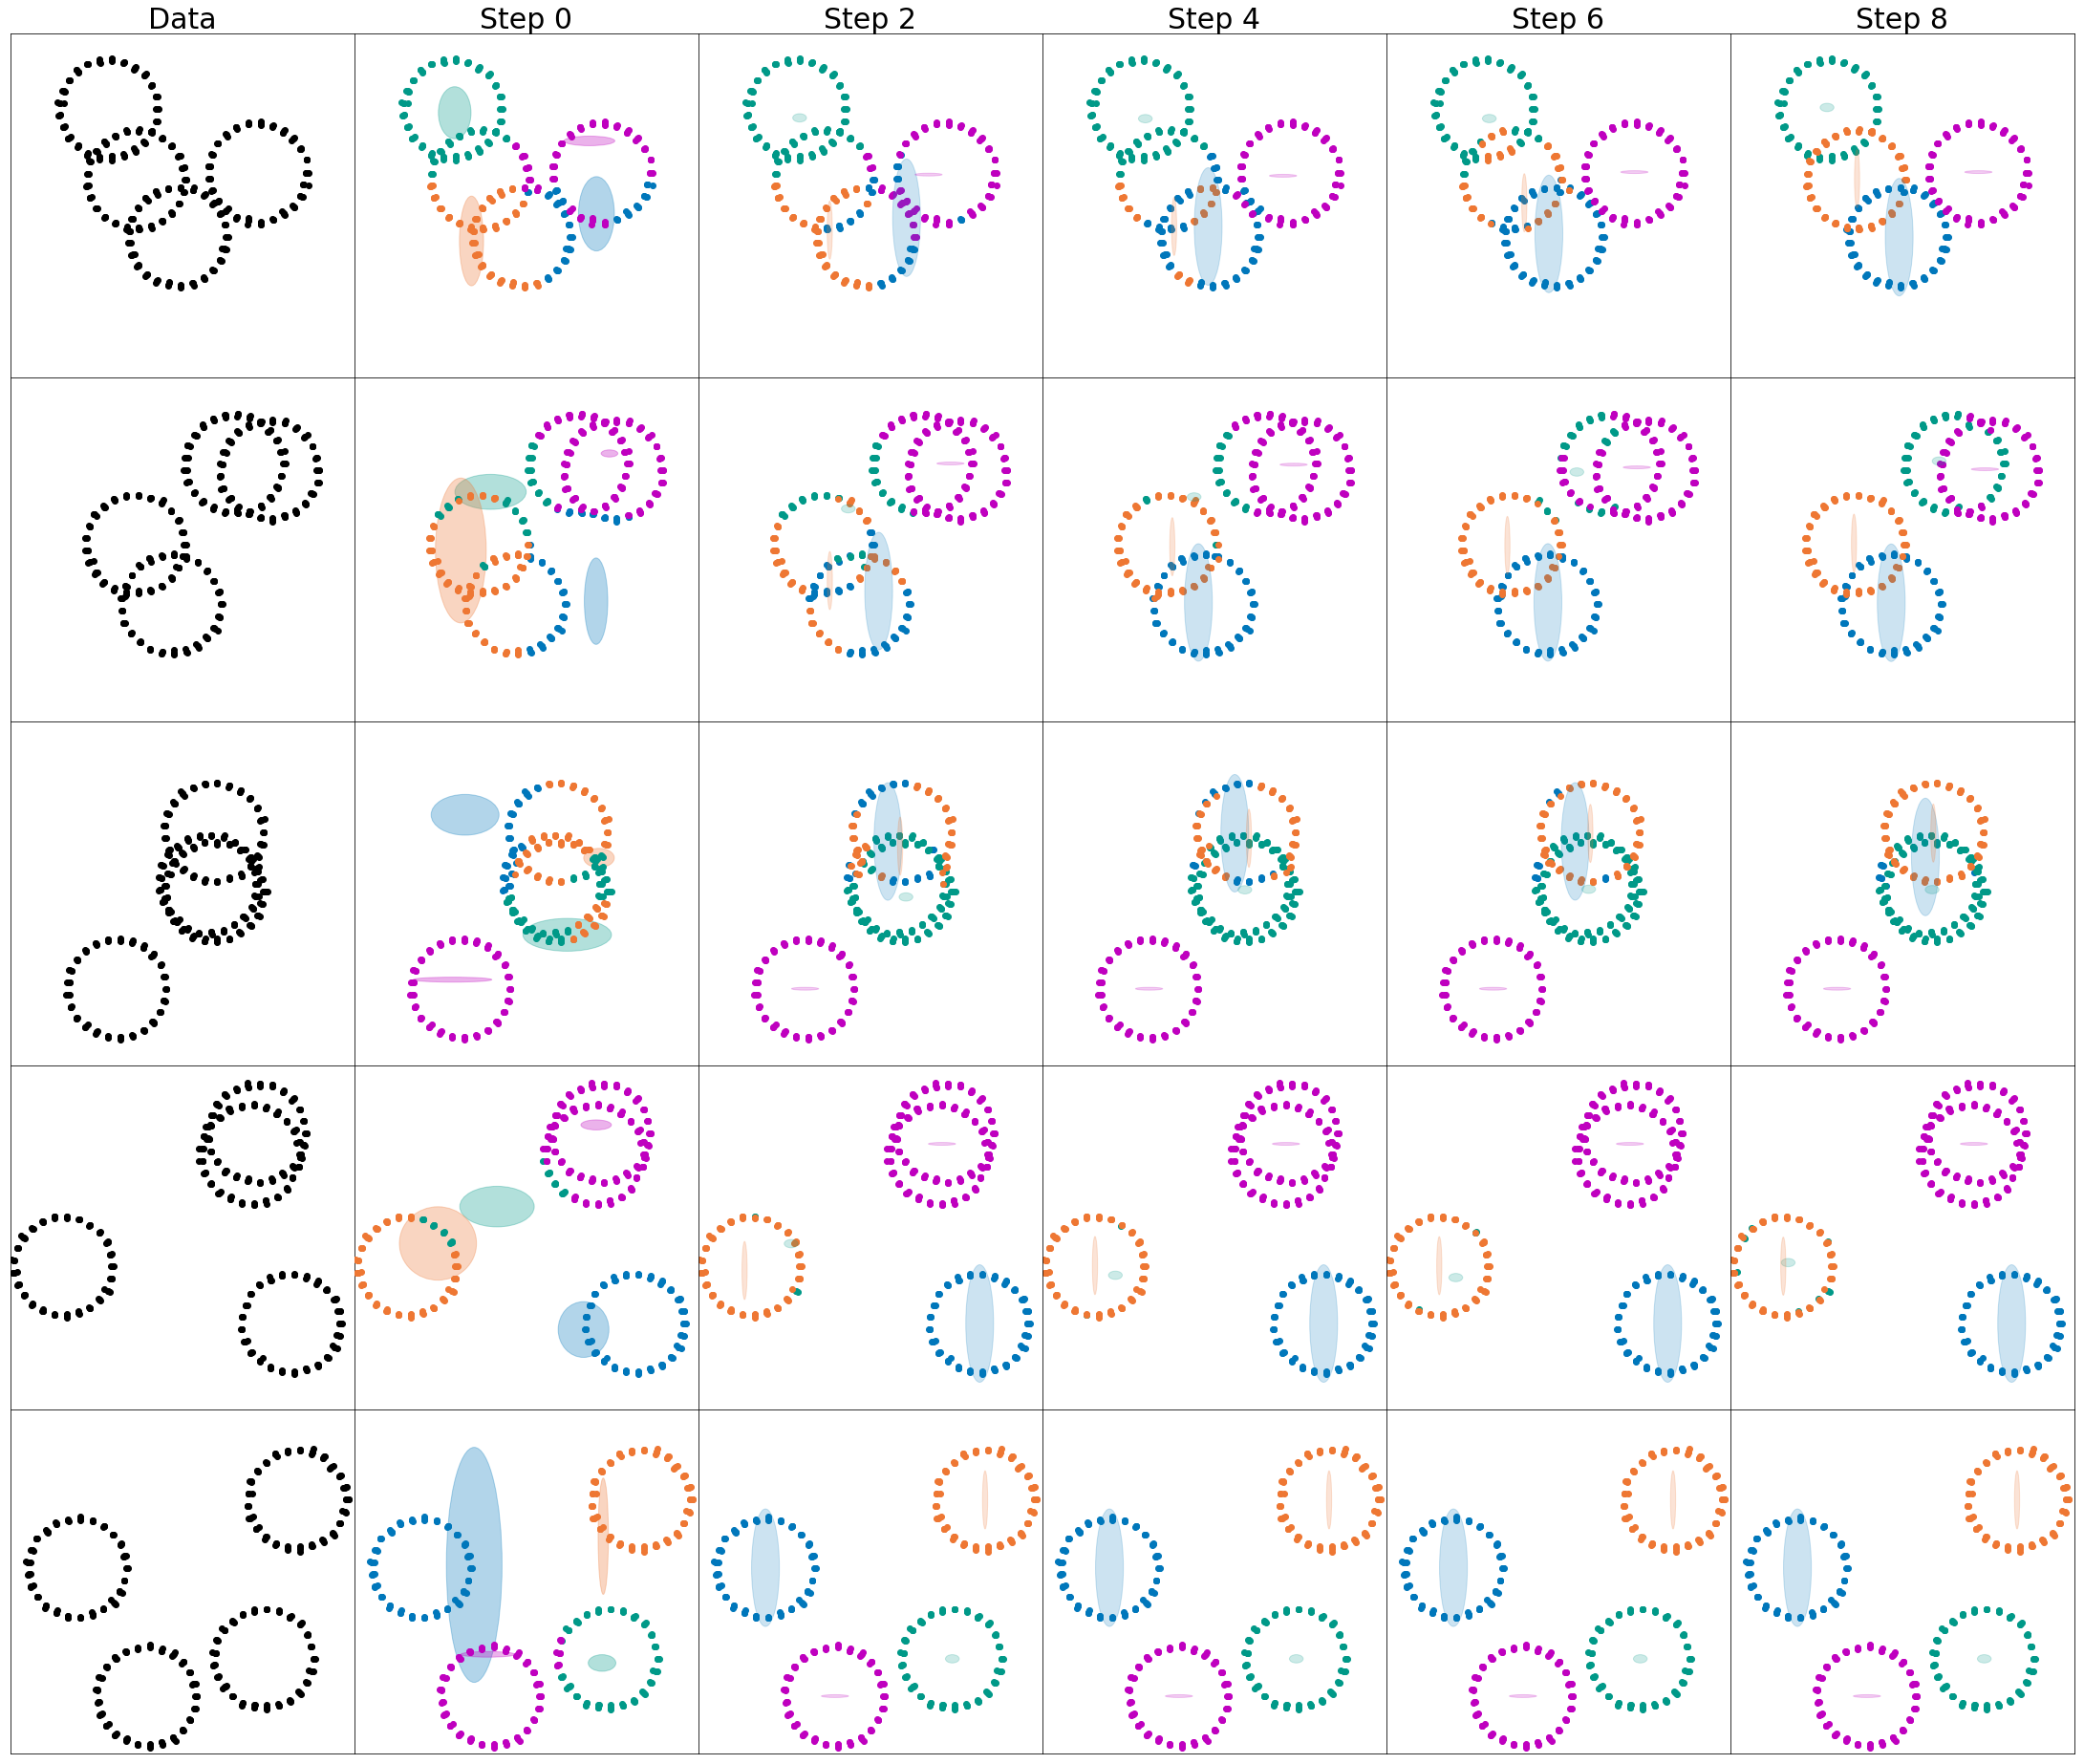

In [12]:
from ag_ep import *
import matplotlib.gridspec as gridspec
MAX_MCMC_STEPS = 8 ## 12 is maximum mcmc steps
SAMPLE_SIZE = 1
BATCH_SIZE = 5
Vis_Interval = 2
##
colors = ['#0077BB', '#009988', '#EE7733', 'm']
gs = gridspec.GridSpec(BATCH_SIZE, 2+int(MAX_MCMC_STEPS / Vis_Interval))
gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0, hspace=0)
fig = plt.figure(figsize=(30,25))

indices = torch.arange(NUM_DATASETS)
step = 82
batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
obs = Data[batch_indices]
obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    obs =obs.cuda().to(DEVICE)
    
xs = obs[0].cpu().data.numpy()    
for b in range(BATCH_SIZE):
    xb = xs[b]
    ax = fig.add_subplot(gs[b, 0])
    ax.scatter(xb[:, 0], xb[:, 1], c='k')
    ax.set_ylim([-7, 7])
    ax.set_xlim([-7, 7])
    ax.set_xticks([])
    ax.set_yticks([])
    if b == 0:
        ax.set_title('Data', fontsize=30)
        
q_eta, p_eta = oneshot_mu(obs, K, D, SAMPLE_SIZE, BATCH_SIZE)
log_p_eta = p_eta['means'].log_prob.sum(-1)
log_q_eta = q_eta['means'].log_prob.sum(-1)
obs_mu = q_eta['means'].value
q_z, p_z = enc_z.forward(obs, obs_mu, obs_rad, noise_sigma, N, K, SAMPLE_SIZE, BATCH_SIZE)
log_p_z = p_z['zs'].log_prob
log_q_z = q_z['zs'].log_prob
state = q_z['zs'].value ## S * B * N * K

E_z = q_z['zs'].dist.probs[0].cpu().data.numpy()
E_mu = q_eta['means'].dist.loc[0].cpu().data.numpy()
Sigma_mu = q_eta['means'].dist.scale[0].cpu().data.numpy()

for b in range(BATCH_SIZE):
    ax = fig.add_subplot(gs[b, 1])
    xb = xs[b]
    zb = E_z[b]
    mu = E_mu[b].reshape(K, D)
    sigma = Sigma_mu[b]
    assignments = zb.argmax(-1)
    for k in range(K):
        cov_k = np.diag(sigma[k]**2)
        xk = xb[np.where(assignments == k)]
        ax.scatter(xk[:, 0], xk[:, 1], c=colors[k], zorder=3)
        plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.3, color=colors[k])
    ax.set_ylim([-7, 7])
    ax.set_xlim([-7, 7])
    ax.set_xticks([])
    ax.set_yticks([])
    if b == 0:
        ax.set_title("Step 0", fontsize=30)
log_p_eta = p_eta['means'].log_prob.sum(-1)
log_q_eta = q_eta['means'].log_prob.sum(-1)
log_p_z = p_z['zs'].log_prob
log_q_z = q_z['zs'].log_prob
state = q_z['zs'].value ## S * B * N * K
log_obs_n = True_Log_likelihood(obs, state, obs_mu, obs_rad, noise_sigma, K, D, cluster_flag=False)
log_weights = log_obs_n.sum(-1) + log_p_z.sum(-1) - log_q_z.sum(-1) + log_p_eta.sum(-1) - log_q_eta.sum(-1)        
w_f_z = F.softmax(log_weights, 0).detach()

for m in range(MAX_MCMC_STEPS):
#     if m == 0:
#         state = resample_state(state, w_f_z, idw_flag=False) ## resample state
#     else:
#         state = resample_state(state, w_f_z, idw_flag=True)
    q_eta, p_eta = enc_mu(obs, state, K, SAMPLE_SIZE, BATCH_SIZE)
    obs_mu, log_w_eta_f, log_w_eta_b  = Incremental_eta(q_eta, p_eta, obs, state, obs_rad, noise_sigma, K, D, obs_mu)
#     obs_mu = resample_mu(obs_mu, w_f_eta) ## resample eta
    q_z, p_z = enc_z.forward(obs, obs_mu, obs_rad, noise_sigma, N, K, SAMPLE_SIZE, BATCH_SIZE)    
    state = q_z['zs'].value
    if (m+1) % Vis_Interval == 0:
        E_z = q_z['zs'].dist.probs[0].cpu().data.numpy()
        E_mu = q_eta['means'].dist.loc[0].cpu().data.numpy()
        Sigma_mu = q_eta['means'].dist.scale[0].cpu().data.numpy()
        for b in range(BATCH_SIZE):
            ax = fig.add_subplot(gs[b, 1+int((m+1)/Vis_Interval)])
            xb = xs[b]
            zb = E_z[b]
            mu = E_mu[b].reshape(K, D)
            sigma2 = Sigma_mu[b]
            assignments = zb.argmax(-1)
            for k in range(K):
                cov_k = np.diag(sigma[k] ** 2)
                xk = xb[np.where(assignments == k)]
                ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
                plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=1, ax=ax, alpha=0.2, color=colors[k])
            ax.set_ylim([-7, 7])
            ax.set_xlim([-7, 7])
            ax.set_xticks([])
            ax.set_yticks([])
            if b == 0:
                ax.set_title('Step %d' % (m+1), fontsize=30)
plt.savefig('../results/sample7-rings-' + PATH + '.svg')

In [ ]:
from ag_ep import *
BATCH_SIZE_TEST = 50
Train_Params_Test = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, PATH)

obs, metric_step, reused = test(models, EUBO_fixed_radi, Data, Model_Params, Train_Params_Test)
(q_mu, _, q_z, _) = reused

In [ ]:
%time plot_samples(obs, q_mu, q_z, K, PATH)